## 0. Importing Hannes Functions

In [1]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')

import re


from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

import re



from tqdm import tqdm
tqdm.pandas()


#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [2]:
#additional functions

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
    
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

## 1. Session 8 code - This will do pre-preprocessing with td-idf and SVD. I will try with European Commission today.

In [3]:
#loading the data

path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           1078 non-null   object
 1   Date            1078 non-null   object
 2   Category        1078 non-null   object
 3   Text            1078 non-null   object
 4   text_preproc    1078 non-null   object
 5   titles_preproc  1078 non-null   object
 6   Ukraine         1078 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 59.1+ KB


In [4]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(EC_data.text_preproc)



vectorized_text=cv.transform(EC_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (1078, 67295)


In [5]:
vectorized_title=cv.transform(EC_data.titles_preproc)
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (1078, 67295)


In [6]:
dtm=2*vectorized_title+vectorized_text

In [7]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_

print("U (document-topic matrix):\n", U)
print("\nSigma (singular values):\n", Sigma)
print("\nVT (topic-term matrix):\n", VT)


U (document-topic matrix):
 [[ 7.95531642 -0.95958118 -8.91247243 ... -3.96697388 -1.29658253
   3.27831039]
 [ 2.71863477 -1.05557989 -0.63099263 ... -0.21622344  0.78549452
  -1.34877286]
 [ 2.16771955 -0.71458249 -3.10260632 ... -1.38742491 -0.75266068
   1.09380933]
 ...
 [ 4.95556973 -1.66460196 -1.24583727 ... -1.66024856  0.3761282
  -3.50133841]
 [ 2.48955421 -1.08882407 -0.16453318 ... -0.04422638  0.47579894
  -1.29283081]
 [ 7.97465927 -0.07521619 -0.98553825 ... -1.71929196 -0.19598814
  -2.039198  ]]

Sigma (singular values):
 [494.64964785 337.54086777 253.3431575  207.94302208 201.28223068
 182.44737033 166.34073969 161.088226   155.75250174 147.05894304]

VT (topic-term matrix):
 [[ 7.27449564e-04  1.45029620e-04  2.72461688e-04 ...  9.06666585e-04
   1.45967184e-04  9.08488748e-05]
 [-4.90437440e-04 -1.34378681e-04 -7.13608786e-05 ... -5.54426308e-04
  -9.06305760e-05 -7.53375071e-05]
 [-1.46310935e-04  7.60215759e-05 -5.65316822e-04 ... -5.24070952e-04
  -1.01907332e-

In [8]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ukraine', 0.26415784082168076), ('resilience', 0.1554985400973438), ('recovery', 0.1553569471709154), ('digital', 0.14402976765833728), ('transition', 0.12282367642495672)]
Topic 2:  [('resilience', 0.3592813305397056), ('recovery', 0.3395940177727141), ('recovery resilience', 0.3272139936725812), ('resilience plan', 0.19439697992590835), ('reform', 0.1636264465619359)]
Topic 3:  [('ukraine', 0.6818120278825381), ('war', 0.14513806458031348), ('russia', 0.13727242899385425), ('ukrainian', 0.12880540965244747), ('recovery', 0.09046813111442585)]
Topic 4:  [('vaccine', 0.5712985264810242), ('health', 0.237022030401433), ('covid19', 0.19449802610349778), ('africa', 0.15504216628063716), ('dose', 0.12537950607234707)]
Topic 5:  [('security', 0.15824697516058747), ('health', 0.15816849611239506), ('canada', 0.1360637810433461), ('development', 0.12393573896889915), ('ukraine', 0.11698367580823989)]
Topic 6:  [('transition', 0.24085639581979026), ('ukraine', 0.22313926530401929)

In [9]:
#exploring artricles/topic loadings in this representation
print(U.shape)
second_row_of_U = U[1, :]
print("Second row of U:", second_row_of_U)


#remember article two was very much topic 1 - let's check the article
EC_data.Text[1]

(1078, 10)
Second row of U: [ 2.71863477 -1.05557989 -0.63099263  1.07592783 -0.92719874 -1.01414947
 -1.57482013 -0.21622344  0.78549452 -1.34877286]


'  What happened in Washington yesterday is as appalling as it is outrageous.\nHowever, the fact that on the same night, Joe Biden was confirmed as the next American President shows how resilient the American democracy is.\nJoe Biden now has a daunting task ahead of him. He must bring peace and unity; he must bridge deep divides and he must address the big issues of the future – overcoming the pandemic, how to deal with the global economic crisis as a result of this pandemic, how to protect our planet from climate change, how to advance digitalisation and above all, how to strengthen democracy.\nEurope stands ready to work very closely with the new American President on all these issues. After these four very arid years that we have experienced, we are now looking forward to four fruitful years of dialogue, cooperation and good collaboration.'

In [10]:
# Assuming Sigma contains the singular values from an SVD operation
total_variance = sum(Sigma**2)
variance_explained = [(i**2) / total_variance for i in Sigma]
cumulative_variance_explained = np.cumsum(variance_explained)

# Printing variance explained by each component
for i, variance in enumerate(variance_explained):
    print(f"Component {i+1}: Variance explained: {variance*100:.2f}%")

# Printing cumulative variance explained
print("\nCumulative variance explained by components:")
for i, cumulative_variance in enumerate(cumulative_variance_explained):
    print(f"Components 1 to {i+1}: Cumulative variance explained: {cumulative_variance*100:.2f}%")

Component 1: Variance explained: 38.27%
Component 2: Variance explained: 17.82%
Component 3: Variance explained: 10.04%
Component 4: Variance explained: 6.76%
Component 5: Variance explained: 6.34%
Component 6: Variance explained: 5.21%
Component 7: Variance explained: 4.33%
Component 8: Variance explained: 4.06%
Component 9: Variance explained: 3.79%
Component 10: Variance explained: 3.38%

Cumulative variance explained by components:
Components 1 to 1: Cumulative variance explained: 38.27%
Components 1 to 2: Cumulative variance explained: 56.09%
Components 1 to 3: Cumulative variance explained: 66.13%
Components 1 to 4: Cumulative variance explained: 72.89%
Components 1 to 5: Cumulative variance explained: 79.23%
Components 1 to 6: Cumulative variance explained: 84.44%
Components 1 to 7: Cumulative variance explained: 88.76%
Components 1 to 8: Cumulative variance explained: 92.82%
Components 1 to 9: Cumulative variance explained: 96.62%
Components 1 to 10: Cumulative variance explain

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with your desired parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=0.02, max_df=0.6, stop_words='english')

# Fit and transform your text data using TF-IDF vectorizer
tfidf_matrix_text = tfidf_vectorizer.fit_transform(EC_data.text_preproc)
tfidf_matrix_title = tfidf_vectorizer.transform(EC_data.text_preproc)

# If you want to combine title and text information, do so here

# Perform Singular Value Decomposition (SVD) on TF-IDF matrices
svd = TruncatedSVD(n_components=10)
U_text = svd.fit_transform(tfidf_matrix_text)
U_title = svd.transform(tfidf_matrix_title)

# Now you can observe the resulting topics extracted from both text and title information


In [16]:
# Print the top words associated with each topic for Count Vectorization
print("Top words associated with each topic (Count Vectorization):")
feature_names_count = cv.get_feature_names_out()
for topic_idx, topic in enumerate(VT):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_count[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Print the top words associated with each topic for TF-IDF Vectorization
print("\nTop words associated with each topic (TF-IDF Vectorization):")
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(svd.components_):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_tfidf[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Top words associated with each topic (Count Vectorization):
Topic 1: ukraine, resilience, recovery, digital, transition, recovery resilience, reform, security, russia, von
Topic 2: resilience, recovery, recovery resilience, resilience plan, reform, assessment, digital, rrf, resilience facility, facility
Topic 3: ukraine, war, russia, ukrainian, recovery, financial, assistance, russian, reform, recovery resilience
Topic 4: vaccine, health, covid19, africa, dose, pandemic, team, team europe, production, covid19 vaccine
Topic 5: security, health, canada, development, ukraine, vaccine, partnership, welcome, strengthen, commitment
Topic 6: transition, ukraine, viet, nam, viet nam, emission, renewable, energy transition, hydrogen, financial
Topic 7: defence, gas, supply, vaccine, price, industry, security, critical, industrial, russia
Topic 8: raw, hydrogen, material, raw material, gateway, critical, global gateway, critical raw, digital, ukraine
Topic 9: payment, request, preliminary assess

In [14]:
def run_topic_modeling_with_titles(data, min_df, max_df):
    # Setup vectorizers
    cv_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=min_df, max_df=max_df)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=min_df, max_df=max_df)
    
    # Fit CountVectorizer on text and transform both text and titles
    cv_text_matrix = cv_vectorizer.fit_transform(data['text_preproc'])
    cv_titles_matrix = cv_vectorizer.transform(data['titles_preproc'])
    # Weight titles twice as much as text
    cv_combined_matrix = 2 * cv_titles_matrix + cv_text_matrix
    
    # Fit TF-IDF Vectorizer on text and transform both text and titles
    tfidf_text_matrix = tfidf_vectorizer.fit_transform(data['text_preproc'])
    tfidf_titles_matrix = tfidf_vectorizer.transform(data['titles_preproc'])
    # Weight titles twice as much as text
    tfidf_combined_matrix = 2 * tfidf_titles_matrix + tfidf_text_matrix
    
    # Apply SVD on the combined Count Vectorized data
    cv_svd = TruncatedSVD(n_components=10)
    cv_svd.fit(cv_combined_matrix)
    
    # Apply SVD on the combined TF-IDF data
    tfidf_svd = TruncatedSVD(n_components=10)
    tfidf_svd.fit(tfidf_combined_matrix)
    
    # Print top words for each topic (Count Vectorization)
    print("Top words associated with each topic (Count Vectorization):")
    feature_names_count = cv_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(cv_svd.components_):
        top_words_idx = topic.argsort()[-10:][::-1]  # Get indices of top 10 words
        top_words = [feature_names_count[i] for i in top_words_idx]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")
    
    # Print top words for each topic (TF-IDF Vectorization)
    print("\nTop words associated with each topic (TF-IDF Vectorization):")
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(tfidf_svd.components_):
        top_words_idx = topic.argsort()[-10:][::-1]  # Get indices of top 10 words
        top_words = [feature_names_tfidf[i] for i in top_words_idx]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

run_topic_modeling_with_titles(EC_data, min_df=0.001, max_df=0.4)

Top words associated with each topic (Count Vectorization):
Topic 1: ukraine, recovery, resilience, digital, transition, russia, security, reform, von, der
Topic 2: resilience, recovery, recovery resilience, resilience plan, reform, assessment, digital, rrf, resilience facility, facility
Topic 3: ukraine, war, russia, ukrainian, recovery, financial, assistance, russian, reform, recovery resilience
Topic 4: security, canada, partnership, ukraine, development, sustainable, commitment, welcome, strengthen, trade
Topic 5: vaccine, health, covid19, africa, ukraine, dose, team, team europe, pandemic, production
Topic 6: transition, ukraine, hydrogen, renewable, viet, viet nam, nam, emission, energy transition, clean
Topic 7: defence, gas, supply, vaccine, price, industry, security, critical, industrial, russia
Topic 8: raw, hydrogen, material, raw material, critical, gateway, global gateway, critical raw, digital, chain
Topic 9: payment, request, preliminary assessment, preliminary, payment 

In [ ]:
run_topic_modeling_with_titles(EC_data, min_df=0.002, max_df=0.6)

## 2. Session 9 code - This will apply LDA 

In [166]:
#loading the data
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           1078 non-null   object
 1   Date            1078 non-null   object
 2   Category        1078 non-null   object
 3   Text            1078 non-null   object
 4   text_preproc    1078 non-null   object
 5   titles_preproc  1078 non-null   object
 6   Ukraine         1078 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 59.1+ KB


In [167]:
#now we will not touch the text with the CV as we have pre-processed already
cv = CountVectorizer(ngram_range = (1,2), lowercase=False, min_df=0.01, max_df=0.4)
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(EC_data.text_preproc)

vectorized_text=cv.transform(EC_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

vectorized_title=cv.transform(EC_data.titles_preproc)
vectorized_title=vectorized_title.toarray()
print("document term matrix for titles has size", vectorized_title.shape)

dtm=2*vectorized_title+vectorized_text

document term matrix has size (1078, 7467)
document term matrix for titles has size (1078, 7467)


In [168]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix


In [169]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [170]:
# Number of topics
num_topics = 15

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=10)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("    ")

(0, '0.023*"ukraine" + 0.014*"russia" + 0.009*"war" + 0.009*"russian" + 0.006*"sanction" + 0.006*"president von" + 0.006*"der" + 0.006*"leyen" + 0.005*"von" + 0.005*"von der" + 0.005*"der leyen" + 0.005*"ukrainian" + 0.005*"putin" + 0.005*"EUR" + 0.005*"stand" + 0.004*"minister" + 0.004*"prime" + 0.004*"prime minister" + 0.004*"statement" + 0.004*"security" + 0.003*"border" + 0.003*"course" + 0.003*"discuss" + 0.003*"statement president" + 0.003*"food" + 0.003*"migration" + 0.003*"many" + 0.003*"solidarity" + 0.003*"example" + 0.003*"humanitarian"')
    
(1, '0.022*"defence" + 0.017*"AI" + 0.015*"agreement" + 0.011*"ireland" + 0.008*"act" + 0.007*"UK" + 0.007*"security" + 0.006*"intelligence" + 0.006*"innovation" + 0.006*"joint" + 0.006*"risk" + 0.006*"european defence" + 0.006*"framework" + 0.006*"northern" + 0.006*"northern ireland" + 0.006*"artificial intelligence" + 0.006*"artificial" + 0.005*"industrial" + 0.005*"system" + 0.005*"research" + 0.005*"council" + 0.005*"capability" + 

In [171]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics[0])

#Scroll back to the top and inspect the first article. This checks out!

[(0, 0.0001452698), (1, 0.00014526995), (2, 0.00014526985), (3, 0.00014526985), (4, 0.99796623), (5, 0.00014526985), (6, 0.00014526989), (7, 0.00014526982), (8, 0.00014526988), (9, 0.0001452701), (10, 0.00014526982), (11, 0.00014526983), (12, 0.00014526992), (13, 0.00014526983), (14, 0.00014526982)]


In [172]:
#I ignored word cloud.

In [173]:

# Initialize the columns for each topic with default value 0
for topic_num in range(15):
    EC_data[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        EC_data.at[i, f'topic_{topic_num}'] = prob

EC_data

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0,0.000145,0.000145,0.000145,...,0.000145,0.000145,0.000145,0.000145,0.000145,0.000145,0.000145,0.000145,0.000145,0.000145
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0,0.117699,0.000741,0.000741,...,0.000741,0.000741,0.000741,0.346488,0.000741,0.380307,0.147354,0.000741,0.000741,0.000741
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0,0.000551,0.000551,0.000551,...,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551,0.000551
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0,0.000174,0.000174,0.000174,...,0.000174,0.000174,0.207569,0.143653,0.000174,0.000174,0.000174,0.053288,0.593572,0.000174
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0,0.000132,0.000132,0.000132,...,0.000132,0.000132,0.000132,0.000132,0.000132,0.000132,0.000132,0.000132,0.000132,0.000132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,Commission proposes to change international st...,2023-12-20,Press Release,"Today, the Commission is tabling a proposal fo...",today commission table proposal council decisi...,commission propose change international status...,0,0.000130,0.000130,0.000130,...,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.998176,0.000130,0.000130
1074,Commission welcomes the major progress achieve...,2023-12-20,Statement,The political agreement reached today by the E...,political agreement reach today european parli...,commission welcome major progress achieve parl...,0,0.499053,0.257850,0.000223,...,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.240420,0.000223,0.000223
1075,Statement by President von der Leyen on the po...,2023-12-20,Statement,"Today, the European Parliament and the Council...",today european parliament council reach long a...,statement president von der leyen political ag...,0,0.774149,0.054544,0.000298,...,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.167734,0.000298,0.000298
1076,Statement by President von der Leyen on the pa...,2023-12-27,Statement,We are all the heirs of Jacques Delors's work ...,heir jacques delors work life vibrant prospero...,statement president von der leyen passing jacq...,0,0.000834,0.000834,0.126844,...,0.000834,0.000834,0.000834,0.000834,0.000834,0.466148,0.397000,0.000834,0.000834,0.000834


In [174]:
#Check this for whether topic shares correctly specified - should add to 1.

# Step 1: Calculate the sum of topic shares for each document
EC_data['topic_sum'] = EC_data[[f'topic_{i}' for i in range(15)]].sum(axis=1)

# Step 2: Create a test column that checks if the sum is close to 1
# We use numpy's isclose function to allow for a small margin of error in floating-point comparisons
import numpy as np
EC_data['sum_is_1'] = np.isclose(EC_data['topic_sum'], 1.0)

# Step 3: Produce summary statistics
# This gives you the count of True and False values in the 'sum_is_1' column
summary_stats = EC_data['sum_is_1'].value_counts()

print(summary_stats)

sum_is_1
True    1078
Name: count, dtype: int64


In [175]:
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
Total alpha prior: 1.0000000521540642


In [176]:
# I needed to add a column with the number of words in the article.

EC_data['length_in_words'] = EC_data['text_preproc'].apply(lambda x: len(x.split()))


In [177]:
# For each topic column, calculate the words attributed to that topic
for i in range(15):
    EC_data[f'words_topic_{i}'] = EC_data[f'topic_{i}'] * EC_data['length_in_words']

In [178]:
#I will create now a column with only year_month so i can group topics by it 

EC_data['year_month'] = pd.to_datetime(EC_data['Date']).dt.strftime('%Y-%m')
print(EC_data.dtypes)



Title               object
Date                object
Category            object
Text                object
text_preproc        object
titles_preproc      object
Ukraine              int64
topic_0            float64
topic_1            float64
topic_2            float64
topic_3            float64
topic_4            float64
topic_5            float64
topic_6            float64
topic_7            float64
topic_8            float64
topic_9            float64
topic_10           float64
topic_11           float64
topic_12           float64
topic_13           float64
topic_14           float64
topic_sum          float64
sum_is_1              bool
length_in_words      int64
words_topic_0      float64
words_topic_1      float64
words_topic_2      float64
words_topic_3      float64
words_topic_4      float64
words_topic_5      float64
words_topic_6      float64
words_topic_7      float64
words_topic_8      float64
words_topic_9      float64
words_topic_10     float64
words_topic_11     float64
w

In [179]:
# Prepare the data for aggregation
aggregation_data = EC_data[['year_month'] + [f'words_topic_{i}' for i in range(15)]]

# Group by year and month, and sum the word counts for topics
grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()

# Now adjust these sums by adding alpha_prior to each topic's word count
# and divide by the total words in each group plus total_alpha_prior
for i in range(15):
    grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(15)]].sum(axis=1) + total_alpha_prior)

# Select only the year, month, and topic share columns for the final DataFrame
final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(15)]
result_df = grouped_data[final_columns]


In [180]:
result_df.head()

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9,topic_share_10,topic_share_11,topic_share_12,topic_share_13,topic_share_14
0,2021-01,0.009021,0.010977,0.013531,0.000175,0.348603,0.009690,0.000175,0.143091,0.017683,0.001275,0.146627,0.042830,0.064747,0.170598,0.020977
1,2021-02,0.003438,0.039382,0.005112,0.044738,0.322736,0.028571,0.000123,0.260489,0.039621,0.001515,0.135906,0.031351,0.060931,0.019797,0.006291
2,2021-03,0.013907,0.006036,0.047232,0.023707,0.194898,0.029544,0.018115,0.132259,0.055215,0.008589,0.145440,0.095011,0.127565,0.046208,0.056276
3,2021-04,0.007444,0.031375,0.039676,0.029052,0.137007,0.007851,0.022385,0.066004,0.196052,0.003778,0.134202,0.057695,0.051700,0.175335,0.040445
4,2021-05,0.010679,0.021207,0.074702,0.011250,0.114734,0.013240,0.054067,0.133321,0.232826,0.001022,0.188283,0.034320,0.070506,0.012905,0.026937


In [181]:
print(result_df.dtypes)


year_month         object
topic_share_0     float64
topic_share_1     float64
topic_share_2     float64
topic_share_3     float64
topic_share_4     float64
topic_share_5     float64
topic_share_6     float64
topic_share_7     float64
topic_share_8     float64
topic_share_9     float64
topic_share_10    float64
topic_share_11    float64
topic_share_12    float64
topic_share_13    float64
topic_share_14    float64
dtype: object


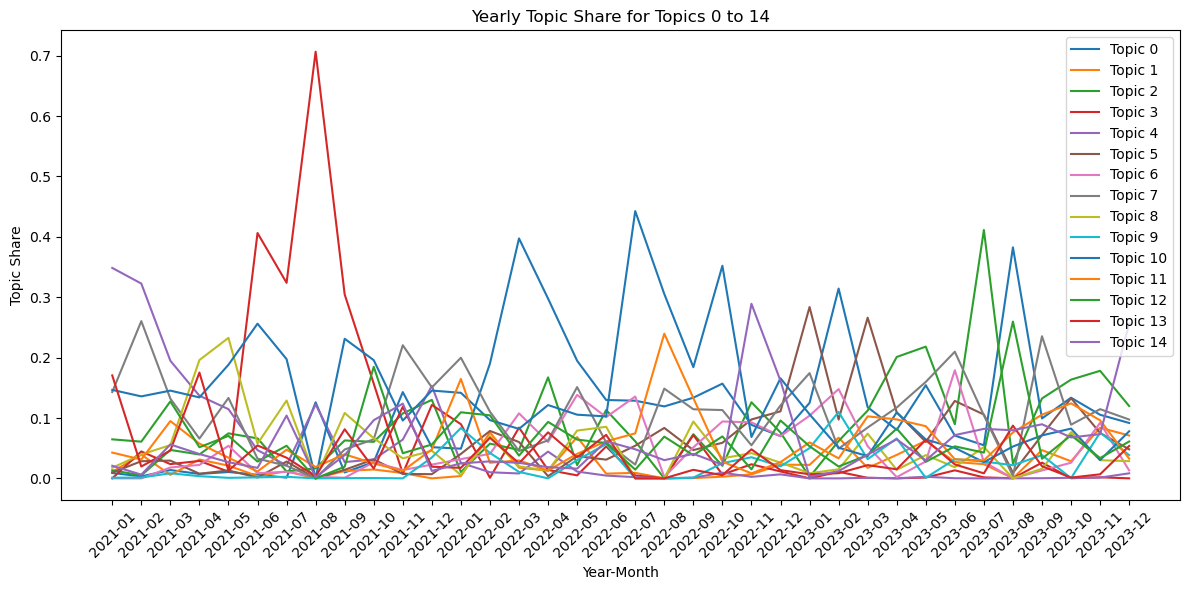

In [182]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
for i in range(15):  # Assuming topic_share columns are named from 'topic_share_0' to 'topic_share_14'
    plt.plot(result_df['year_month'], result_df[f'topic_share_{i}'], label=f'Topic {i}')

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 0 to 14')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()


## 2. Here will be the TA_session

In [183]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import os
import re
from tqdm import tqdm
tqdm.pandas()
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [184]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.head()

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0


In [185]:
#I will not lemmatize as I will did it previously

In [186]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv.fit(EC_data.text_preproc)

vectorized_text=cv.transform(EC_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (1078, 67295)


In [187]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [188]:
# ILLUSTRATION: 
cv2 = CountVectorizer(ngram_range = (1,2), lowercase=True, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv2.fit(EC_data.text_preproc[0:1])
vocabulary = cv2.get_feature_names_out()

print(EC_data.text_preproc[0])
print('\n\n')
print(vocabulary)


today european commission grant conditional marketing authorisation cma COVID19 vaccine develop moderna second COVID19 vaccine authorise EU authorisation follow positive scientific recommendation base thorough assessment safety effectiveness quality vaccine european medicines agency EMA endorse member states president european commission ursula von der leyen say provide covid19 vaccine europeans moderna vaccine second one authorise EU 160 million dose vaccine come europe secure two billion dose potential COVID19 vaccine enough safe effective vaccine protect europeans stella kyriakides commissioner health food safety say together unite negotiate broad vaccine portfolio world member states today authorise second safe effective vaccine moderna together BioNTech pfizer ensure 460 million dose roll increase speed EU come member states ensure pace vaccination follow suit effort stop vaccine available everyone EU moderna submit 30 november 2020 application marketing authorisation EMA already 

In [189]:
EC_data.text_preproc[0]

'today european commission grant conditional marketing authorisation cma COVID19 vaccine develop moderna second COVID19 vaccine authorise EU authorisation follow positive scientific recommendation base thorough assessment safety effectiveness quality vaccine european medicines agency EMA endorse member states president european commission ursula von der leyen say provide covid19 vaccine europeans moderna vaccine second one authorise EU 160 million dose vaccine come europe secure two billion dose potential COVID19 vaccine enough safe effective vaccine protect europeans stella kyriakides commissioner health food safety say together unite negotiate broad vaccine portfolio world member states today authorise second safe effective vaccine moderna together BioNTech pfizer ensure 460 million dose roll increase speed EU come member states ensure pace vaccination follow suit effort stop vaccine available everyone EU moderna submit 30 november 2020 application marketing authorisation EMA already

In [190]:
vectorized_title=cv.transform(EC_data.titles_preproc) # this uses the same vocabulary as the text
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)
dtm=2*vectorized_title+vectorized_text # we give more weight to the title
print(type(dtm))

document term matrix has size (1078, 67295)
<class 'numpy.ndarray'>


In [191]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix

#gensim needs the dtm in a different sparce format (from numpy to csr_matrix)
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items(): # remember cv has been fitted to the data
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_


In [192]:
# Number of topics
num_topics = 10

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.017*"ukraine" + 0.006*"war" + 0.006*"russia" + 0.004*"russian" + 0.004*"ukrainian" + 0.003*"der leyen" + 0.003*"leyen" + 0.003*"der" + 0.003*"von der" + 0.003*"von"')
(1, '0.005*"partnership" + 0.004*"digital" + 0.004*"raw" + 0.003*"sustainable" + 0.003*"von" + 0.003*"leyen" + 0.003*"von der" + 0.003*"der" + 0.003*"der leyen" + 0.003*"critical"')
(2, '0.014*"ukraine" + 0.005*"defence" + 0.005*"assistance" + 0.004*"financial" + 0.004*"food" + 0.004*"russia" + 0.003*"security" + 0.003*"joint" + 0.003*"war" + 0.003*"social"')
(3, '0.006*"china" + 0.003*"trade" + 0.003*"change" + 0.003*"digital" + 0.003*"von" + 0.003*"der" + 0.003*"von der" + 0.003*"leyen" + 0.003*"der leyen" + 0.002*"president von"')
(4, '0.015*"recovery" + 0.015*"resilience" + 0.013*"recovery resilience" + 0.008*"resilience plan" + 0.008*"reform" + 0.006*"digital" + 0.006*"nextgenerationeu" + 0.005*"facility" + 0.005*"assessment" + 0.005*"measure"')
(5, '0.009*"vaccine" + 0.005*"health" + 0.004*"pandemic" + 0.004*

In [193]:
#The goal here is to compare the SVD with the LDA.

from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_


terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ukraine', 0.2641578350585655), ('resilience', 0.1554985469479301), ('recovery', 0.1553569496257442), ('digital', 0.1440296804421471), ('transition', 0.12282368801146228), ('recovery resilience', 0.10975001699456531), ('reform', 0.10966369312398465), ('security', 0.1059630431213499), ('russia', 0.1059481660556673), ('von', 0.10092796993665079)]
Topic 2:  [('resilience', 0.35928092005625106), ('recovery', 0.3395937187208698), ('recovery resilience', 0.32721367327573186), ('resilience plan', 0.19439677983024362), ('reform', 0.16362712771362997), ('assessment', 0.12462401408784882), ('digital', 0.11885945075268432), ('rrf', 0.11837412083779218), ('resilience facility', 0.11732030235905694), ('facility', 0.11546936802904548)]
Topic 3:  [('ukraine', 0.6818085794341906), ('war', 0.14512490878326126), ('russia', 0.13725575584110522), ('ukrainian', 0.12879667541283932), ('recovery', 0.09047760243591785), ('financial', 0.08134754439403943), ('assistance', 0.08125194466635419), ('rus

In [194]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)


In [195]:
#This is to do coherence. It is purely mathematical so it may not be good.

from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.05981897750941

Number of Topics: 2, Coherence: -0.8782604475839862
Number of Topics: 3, Coherence: -0.9319244584022437
Number of Topics: 4, Coherence: -0.8345780247952836
Number of Topics: 5, Coherence: -1.0082073754399974
Number of Topics: 6, Coherence: -1.167015872939552
Number of Topics: 7, Coherence: -0.8405735727376921
Number of Topics: 8, Coherence: -0.962050731923785
Number of Topics: 9, Coherence: -0.8670044397093141
Number of Topics: 10, Coherence: -0.9510124489965698


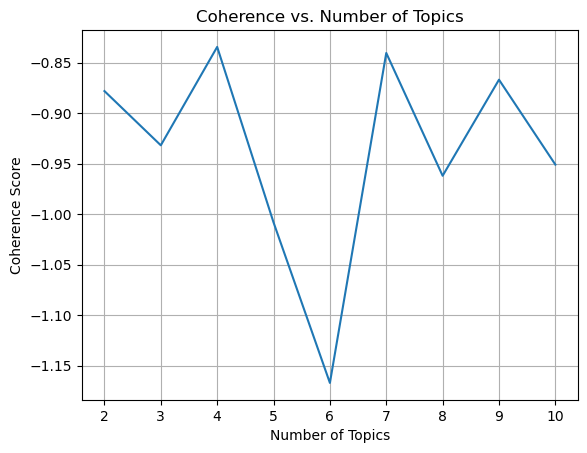

In [196]:
#This took ages to run. As it is quite irrelevant, I would not run it again.


def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []


min_topics = 2
max_topics = 10
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
import matplotlib.pyplot as plt

plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()

In [197]:
#Here we do another LDA, but we change the alpha paramenter. There is a need to understand what is going here.


num_topics = 10
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42,alpha=20)


lda_model.show_topics

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

In [198]:
#Then we have guided LDA, lets not do it now.